In [0]:
from google.colab import drive
drive.mount('/data/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /data/


In [0]:
!ls '/data/My Drive/Colab Notebooks/data'

 clients.csv	 'logs (4).gdoc'   logs.gdoc	   submission.csv
'logs (1).gdoc'  'logs (5).gdoc'   logs.txt	   uplift_sample_submission.csv
'logs (2).gdoc'  'logs (6).gdoc'   products.csv    uplift_test.csv
'logs (3).gdoc'  'logs (7).gdoc'   purchases.csv   uplift_train.csv


In [0]:
path = '/data/My Drive/Colab Notebooks/data'

In [0]:
!pip install catboost
!pip install lightgbm
!pip install pyuplift
!pip install hyperopt
!pip install category_encoders

     |████████████████████████████████| 64.0MB 47kB/s 
  Created wheel for pyuplift: filename=pyuplift-0.0.4.1-cp36-none-any.whl size=38582 sha256=a3a3c89b261abaedab7abf60aa5f842234028effa13c4dc8fb86e76304064ed6
  Stored in directory: /root/.cache/pip/wheels/db/07/08/dc177e09b9bec2c92110829ae98b1df9104c574c19469b49ac
Successfully built pyuplift
     |████████████████████████████████| 102kB 2.2MB/s 


In [0]:
import pandas
import datetime
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

In [0]:
def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    #print(treatment_p, control_p)
    return score

def uplift_fit_predict(model, X_train, treatment_train, target_train, X_test):
    """
    Реализация простого способа построения uplift-модели.
    
    Обучаем два бинарных классификатора, которые оценивают вероятность target для клиента:
    1. с которым была произведена коммуникация (treatment=1)
    2. с которым не было коммуникации (treatment=0)
    
    В качестве оценки uplift для нового клиента берется разница оценок вероятностей:
    Predicted Uplift = P(target|treatment=1) - P(target|treatment=0)
    """
    X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
    X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
    X_treatment_train, X_treatment_test, y_treatment_train, y_treatment_test = train_test_split(X_treatment, y_treatment, test_size=0.2, random_state=241)
    X_control_train, X_control_test, y_control_train, y_control_test = train_test_split(X_control, y_control, test_size=0.2, random_state=241)

   
    model_treatment = clone(model).fit(X_treatment_train, y_treatment_train, eval_set=(X_treatment_test,  y_treatment_test))
    model_control = clone(model).fit(X_control_train, y_control_train, eval_set=(X_control_test, y_control_test))

    predict_treatment = model_treatment.predict_proba(X_test)[:, 1]
    predict_control = model_control.predict_proba(X_test)[:, 1]
    predict_uplift = predict_treatment - predict_control

    return predict_uplift, model_treatment.get_feature_importance(), model_control.get_feature_importance()

In [0]:
def transformtaion(data_df):
    y = data_df['target'].values
    t = data_df['treatment_flg'].values
    z = y*t+(1-y)*(1-t)
    data_df['transform_target'] = z
    return data_df


def uplift_fit_predict_transformation(model, X_train_df, train_df, X_test, valid_split_size=0.3, balanced = True, is_cv=False):
    """
    Реализация способа построения uplift-модели с помощью преобразования целевой переменной.
    
    Создаем новый target zi=yi∗ti+(1−yi)∗(1−ti)
    
    В качестве оценки uplift для нового клиента берется оценка (при условии P(t=1)=P(t=0)=1/2):
    Predicted Uplift = 2*P(z=1) - 1
    """
    if balanced:
      n_max = min(train_df[train_df['treatment_flg'] == 1].shape[0], train_df[train_df['treatment_flg'] == 0].shape[0])

      treatment = train_df[train_df['treatment_flg'] == 1][:n_max]
      control = train_df[train_df['treatment_flg'] == 0][:n_max]

      balanced_df = treatment.append(control)
      balanced_df = balanced_df.iloc[np.random.permutation(len(balanced_df))]

      X_balanced = X_train_df.loc[balanced_df.index].values
      z_balanced = balanced_df['transform_target'].values
    else:
      X_balanced = X_train_df.values
      z_balanced = train_df['transform_target'].values

    if valid_split_size>0:
      X_balanced_train, X_balanced_test, z_balanced_train, z_balanced_test = train_test_split(X_balanced, z_balanced, test_size=valid_split_size, random_state=241)
      model_transformation = clone(model).fit(X_balanced_train, z_balanced_train, eval_set=(X_balanced_test, z_balanced_test))
    else:
      model_transformation = clone(model).fit(X_balanced, z_balanced)

    predict_transformation = model_transformation.predict_proba(X_test)[:, 1]

    predict_uplift = 2 * predict_transformation - 1
    if not is_cv:
      return predict_uplift, model_transformation.get_feature_importance(), model_transformation
    else:
      return predict_uplift, model_transformation

In [0]:
from sklearn.model_selection import KFold, GroupKFold
def cross_val_on_transformation(model, X_train_df, train_df, k_fold=5, min_threshold=0.09, valid_split_size=0.2):
    kf = KFold(n_splits=k_fold, random_state=241, shuffle=True)
    result_models = []
    result_val = []
    i = 0
    for train_index, test_index in kf.split(X_train_df):
        X_train, X_test = X_train_df.iloc[train_index], X_train_df.iloc[test_index]
        y_train, y_test = train_df.iloc[train_index], train_df.iloc[test_index]
        valid_uplift, model = uplift_fit_predict_transformation(model,
                                                                  X_train_df = X_train,
                                                                  train_df = y_train,
                                                                  X_test = X_test,
                                                                  valid_split_size = valid_split_size,
                                                                  balanced = False,
                                                                  is_cv = True
                                                                  )
        valid_score = uplift_score(
            valid_uplift,
            treatment=df_train.iloc[test_index]['treatment_flg'].values,
            target=df_train.iloc[test_index]['target'].values,
        )
        print('Validation score on iter = ', i , ' is ', valid_score)
        i+=1
        if valid_score > min_threshold:
          result_models.append(model)
          result_val.append(valid_score)
    print('Validation score:', np.mean(result_val))
    return result_models, result_val

In [0]:
# Чтение данных
df_products = pandas.read_csv('/data/My Drive/Colab Notebooks/data/products.csv')
df_purchases = pandas.read_csv('/data/My Drive/Colab Notebooks/data/purchases.csv')
df_clients = pandas.read_csv('/data/My Drive/Colab Notebooks/data/clients.csv', index_col='client_id')
df_train = pandas.read_csv('/data/My Drive/Colab Notebooks/data/uplift_train.csv', index_col='client_id')
df_test = pandas.read_csv('/data/My Drive/Colab Notebooks/data/uplift_test.csv', index_col='client_id')

In [0]:
#допилить с фичи с продуктами
products_count = df_purchases[['client_id', 'product_id','product_quantity', 'purchase_sum']].groupby(['client_id','product_id']).agg(['sum'])
min_max_products_count = products_count.sort_values(('purchase_sum', 'sum'), ascending=False).groupby('client_id').head(2)
min_products_summary = min_max_products_count.sort_values(('purchase_sum', 'sum'), ascending=True).groupby('client_id').head(1)
max_products_summary = min_max_products_count.sort_values(('purchase_sum', 'sum'), ascending=False).groupby('client_id').head(1)

clients_products_second = min_products_summary.reset_index().set_index('product_id').join(df_products.set_index('product_id'))
clients_products_second = clients_products_second.rename(columns={('client_id', ''):'client_id'}).set_index('client_id')

clients_products_first = max_products_summary.reset_index().set_index('product_id').join(df_products.set_index('product_id'))
clients_products_first = clients_products_first.rename(columns={('client_id', ''):'client_id'}).set_index('client_id')

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [0]:
purch = df_purchases.groupby(['client_id', 'transaction_id']).last()
purch[['trn_sum_from_red']] = purch[['trn_sum_from_red']].fillna(-100)

purch['points_spent'] = (purch['regular_points_spent']+purch['express_points_spent'])
purch['points_recieved'] = (purch['regular_points_received']+purch['express_points_received'])

In [0]:
now = pandas.to_datetime(df_purchases['transaction_datetime'].max())

In [0]:
def fix_age(df_clients, real_fix=True):

    # create a copy of age column. Modify the copy for now
    df_clients['age2'] = df_clients['age']
    
    age_index = (df_clients['age'] < -900) & (df_clients['age'] > -1000)
    df_clients.loc[age_index, 'age2'] = -1 * df_clients.loc[age_index, 'age'] + 1019
    df_clients.loc[age_index, 'age_antinorm'] = 1

    age_index = (df_clients['age'] > 900) & (df_clients['age'] < 1000)
    df_clients.loc[age_index, 'age2'] = 1019 - df_clients.loc[age_index, 'age']
    df_clients.loc[age_index, 'age_antinorm'] = 2

    age_index = (df_clients['age'] > 1900) & (df_clients['age'] < 2000)
    df_clients.loc[age_index, 'age2'] = 2019 - df_clients.loc[age_index, 'age']
    df_clients.loc[age_index, 'age_antinorm'] = 3
    
    age_index = (df_clients['age'] > 120) & (df_clients['age'] < 200)
    df_clients.loc[age_index, 'age2'] = df_clients.loc[age_index, 'age'] - 100
    df_clients.loc[age_index, 'age_antinorm'] = 4

    age_index = (df_clients['age'] > 1800) & (df_clients['age'] < 1900)
    df_clients.loc[age_index, 'age2'] = df_clients.loc[age_index, 'age'] - 1800
    df_clients.loc[age_index, 'age_antinorm'] = 5

    # the following types of errors are impossible to recover
    # so we set the age to mean of all clients (46), slightly randomizing it (std=16)
    age_index = (df_clients['age'] > 120)
    df_clients.loc[age_index, 'age2'] = normalvariate(46, 16)
    df_clients.loc[age_index, 'age_antinorm'] = 6
    
    age_index = (df_clients['age'] > 0) & (df_clients['age'] < 12)
    df_clients.loc[age_index, 'age2'] = normalvariate(46, 16)
    df_clients.loc[age_index, 'age_antinorm'] = 7
    
    age_index = (df_clients['age'] == 0)
    df_clients.loc[age_index, 'age2'] = normalvariate(46, 16)
    df_clients.loc[age_index, 'age_antinorm'] = 8
    
    age_index = (df_clients['age'] < 0)
    df_clients.loc[age_index, 'age2'] = normalvariate(46, 16)
    df_clients.loc[age_index, 'age_antinorm'] = 9
    
    # use the modified copy 
    if (real_fix):
        df_clients['age'] = df_clients['age2']
    
    df_clients.drop('age2', axis=1, inplace=True)
    
    return df_clients

In [0]:
from random import normalvariate

df_clients['age_antinorm'] = 0
df_clients = fix_age(df_clients)

In [0]:
# Извлечение признаков
import datetime, time

df_purchases['transaction_datetime'] = pandas.to_datetime(df_purchases['transaction_datetime'])
df_purchases['time_from_purshase'] = abs(df_purchases['transaction_datetime'] - now).astype(int)/10**9/86400
df_purchases[['trn_sum_from_red']] = df_purchases[['trn_sum_from_red']].fillna(-100)

df_purchases['points_spent'] = (df_purchases['regular_points_spent']+df_purchases['express_points_spent'])
products_count = df_purchases[['client_id', 'product_quantity']].groupby(['client_id']).agg(['sum'])
df_purchases['points_recieved'] = (df_purchases['regular_points_received']+df_purchases['express_points_received'])

df_clients['first_issue_unixtime'] = pandas.to_datetime(df_clients['first_issue_date']).astype(int)/10**9
df_clients['first_redeem_unixtime'] = pandas.to_datetime(df_clients['first_redeem_date']).astype(int)/10**9
df_features = pandas.DataFrame({
    'gender': df_clients['gender'],
    'age': df_clients['age'].values,
    'age_antinorm': df_clients['age_antinorm'],
    'first_issue_time': df_clients['first_issue_unixtime'],
    'first_redeem_time': df_clients['first_redeem_unixtime'],
    'issue_redeem_delay': df_clients['first_redeem_unixtime'] - df_clients['first_issue_unixtime'],

    'shop_count': df_purchases[['client_id', 'store_id']].drop_duplicates().groupby(['client_id']).agg(['count'])[('store_id', 'count')],
    'purchases_count': df_purchases.groupby(['client_id','transaction_id']).agg('count').groupby(['client_id']).count()['transaction_datetime'],
    'products_count': df_purchases[['client_id', 'transaction_id']].groupby(['client_id']).agg(['count'])[('transaction_id', 'count')],
    'sum_quantity_products': products_count[('product_quantity', 'sum')],
    'time_from_last_purchase': df_purchases[['client_id', 'time_from_purshase']].groupby(['client_id']).agg(['min'])[('time_from_purshase', 'min')].values,
    'sum_new': purch.reset_index()[['client_id','purchase_sum']].groupby(['client_id']).agg(['count', 'sum'])[('purchase_sum', 'sum')],
    'points_spent_new': purch.reset_index()[['client_id','points_spent']].groupby(['client_id']).agg(['sum'])[('points_spent', 'sum')].abs(),
    'sum_trn_sum_from_iss_new': purch.reset_index()[['client_id','trn_sum_from_iss']].groupby(['client_id']).agg(['sum'])[('trn_sum_from_iss', 'sum')],
    'points_recieved_new': purch.reset_index()[['client_id','points_recieved']].groupby(['client_id']).agg(['sum'])[('points_recieved', 'sum')].abs(),
    'regular_points_received_new': purch.reset_index()[['client_id','regular_points_received']].groupby(['client_id']).agg(['sum'])[('regular_points_received', 'sum')].abs(),
    'express_points_received_new': purch.reset_index()[['client_id','express_points_received']].groupby(['client_id']).agg(['sum'])[('express_points_received', 'sum')].abs(),
    'regular_points_spent_new': purch.reset_index()[['client_id','regular_points_spent']].groupby(['client_id']).agg(['sum'])[('regular_points_spent', 'sum')].abs(),
    'express_points_spent_new': purch.reset_index()[['client_id','express_points_spent']].groupby(['client_id']).agg(['sum'])[('express_points_spent', 'sum')].abs(),
    'purchase_max_new': purch.reset_index()[['client_id','transaction_id','purchase_sum']].groupby(['client_id']).agg(['max'])[('purchase_sum','max')],

}).fillna(0)

In [0]:
######
df_features['sum_new'] = purch.reset_index()[['client_id','purchase_sum']].groupby(['client_id']).agg(['count', 'sum'])[('purchase_sum', 'sum')]
df_features['points_spent_new'] = purch.reset_index()[['client_id','points_spent']].groupby(['client_id']).agg(['sum'])[('points_spent', 'sum')].abs()
df_features['sum_trn_sum_from_iss_new'] = purch.reset_index()[['client_id','trn_sum_from_iss']].groupby(['client_id']).agg(['sum'])[('trn_sum_from_iss', 'sum')]
df_features['points_recieved_new'] = purch.reset_index()[['client_id','points_recieved']].groupby(['client_id']).agg(['sum'])[('points_recieved', 'sum')].abs()
df_features['regular_points_received_new'] = purch.reset_index()[['client_id','regular_points_received']].groupby(['client_id']).agg(['sum'])[('regular_points_received', 'sum')].abs()
df_features['express_points_received_new'] = purch.reset_index()[['client_id','express_points_received']].groupby(['client_id']).agg(['sum'])[('express_points_received', 'sum')].abs()
df_features['regular_points_spent_new'] = purch.reset_index()[['client_id','regular_points_spent']].groupby(['client_id']).agg(['sum'])[('regular_points_spent', 'sum')].abs()
df_features['express_points_spent_new'] = purch.reset_index()[['client_id','express_points_spent']].groupby(['client_id']).agg(['sum'])[('express_points_spent', 'sum')].abs()
df_features['purchase_max_new'] = purch.reset_index()[['client_id','transaction_id','purchase_sum']].groupby(['client_id']).agg(['max'])[('purchase_sum','max')]

In [0]:
########
df_features['purchase_min_new'] = purch.reset_index()[['client_id','purchase_sum']].groupby(['client_id']).agg(['min'])[('purchase_sum','min')]
df_features['purchase_mean_new'] = purch.reset_index()[['client_id','purchase_sum']].groupby(['client_id']).agg(['mean'])[('purchase_sum','mean')]
df_features['points_now_new'] = df_features['points_recieved_new'] - df_features['points_spent_new']
df_features['mean_trn_sum_from_red_new'] = purch.reset_index()[['client_id', 'trn_sum_from_red']].groupby(['client_id']).agg('mean')
df_features['max_trn_sum_from_red_new'] = purch.reset_index()[['client_id', 'trn_sum_from_red']].groupby(['client_id']).agg('max')

In [0]:
import datetime, time
now = time.mktime(datetime.datetime.now().timetuple())

last_cols = ['regular_points_received', 'express_points_received','regular_points_spent', 'express_points_spent', 'purchase_sum','store_id']
last_month = df_purchases[df_purchases['transaction_datetime'] > '2019-02-18'].groupby(['client_id','transaction_id'])[last_cols].last()
last = purch.sort_values(('transaction_datetime'), ascending=False).reset_index().groupby('client_id').head(1)

In [0]:

df_features['unique_products'] = df_purchases[['client_id','product_id']].drop_duplicates().groupby(['client_id']).agg('count')
df_features['purchase_frequency_from_issue'] = abs(df_features['first_issue_time'] - now)/86400/df_features['purchases_count']
df_features['purchase_frequency_from_redeem'] = abs(df_features['first_redeem_time'] - now)/86400/df_features['purchases_count']
df_features['purchase_min_new'] = purch.reset_index()[['client_id','purchase_sum']].groupby(['client_id']).agg(['min'])[('purchase_sum','min')]
df_features['purchase_mean_new'] = purch.reset_index()[['client_id','purchase_sum']].groupby(['client_id']).agg(['mean'])[('purchase_sum','mean')]
df_features['points_now_new'] = df_features['points_recieved_new'] - df_features['points_spent_new']
df_features['mean_trn_sum_from_red_new'] = purch.reset_index()[['client_id', 'trn_sum_from_red']].groupby(['client_id']).agg('mean')#

df_features['favorite_product_sum'] = clients_products_first[('purchase_sum', 'sum')]
df_features['favorite_product_quantity'] = clients_products_first[('product_quantity', 'sum')]
df_features['favorite_product_level_1'] = clients_products_first['level_1']
df_features['favorite_product_level_2'] = clients_products_first['level_2']
df_features['favorite_product_level_3'] = clients_products_first['level_3']
df_features['favorite_product_level_4'] = clients_products_first['level_4']
df_features['favorite_product_brand_id'] = clients_products_first['brand_id']
df_features['favorite_product_vendor_id'] = clients_products_first['vendor_id']
df_features['favorite_segment_id'] = clients_products_first['segment_id']

df_features['last_month_trans_count'] = last_month.groupby('client_id')['purchase_sum'].count()

df_features['second_product_sum'] = clients_products_second[('purchase_sum', 'sum')]


"\ndf_features['second_product_quantity'] = clients_products_second[('product_quantity', 'sum')]\ndf_features['second_product_level_1'] = clients_products_second['level_1']\ndf_features['second_product_level_2'] = clients_products_second['level_2']\ndf_features['second_product_level_3'] = clients_products_second['level_3']\ndf_features['second_product_level_4'] = clients_products_second['level_4']\ndf_features['second_product_brand_id'] = clients_products_second['brand_id']\ndf_features['second_product_vendor_id'] = clients_products_second['vendor_id']\ndf_features['second_segment_id'] = clients_products_second['segment_id']\n"

In [0]:
df_features['is_favorite_alcohol'] = clients_products_first['is_alcohol']
df_features['is_favorite_own_trademark'] = clients_products_first['is_own_trademark']

df_features['is_favorite_alcohol_2'] = clients_products_second['is_alcohol']
df_features['is_favorite_own_trademark_2'] = clients_products_second['is_own_trademark']

In [0]:
last = last.set_index('client_id')

In [0]:
last.head()

,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,points_spent,points_recieved
client_id,,,,,,,,,,,,,,
a22bcaa89b,93c82651c2,2019-03-18 23:40:03,0.6,0.0,0.0,0.0,238.00,7b99761f4a,2b83c48c7b,1.0,133.0,-100.0,0.0,0.6
b02689e4f5,bc1871b256,2019-03-18 23:30:03,0.8,0.0,0.0,0.0,89.00,542372f882,779bd48231,1.0,30.0,-100.0,0.0,0.8
b4895597c3,358bab2efa,2019-03-18 23:19:28,1.0,0.0,0.0,0.0,201.96,f22887774a,11117845fa,3.0,102.0,-100.0,0.0,1.0
a322950c60,1f0c8aaa13,2019-03-18 23:07:56,0.3,0.0,0.0,0.0,69.00,5497605254,71bbfbe471,1.0,70.0,-100.0,0.0,0.3
0b59c69f0d,bc44ffa204,2019-03-18 23:01:51,0.4,0.0,0.0,0.0,84.18,3535a102f1,b673c6253c,1.0,28.0,-100.0,0.0,0.4


In [0]:
df_features['last_purchase_day'] = pandas.to_datetime(last['transaction_datetime']).dt.day
df_features['last_purchase_month'] = pandas.to_datetime(last['transaction_datetime']).dt.month
df_features['last_purchase_hour'] = pandas.to_datetime(last['transaction_datetime']).dt.hour
df_features['last_purchase_dayofweek'] = pandas.to_datetime(last['transaction_datetime']).dt.dayofweek
df_features['last_purchase_isweekend'] = df_features['last_purchase_dayofweek']>5

In [0]:
df_features['last_purchase_trans_sum'] = last['purchase_sum']
df_features['last_purchase_regular_points_received'] = last['regular_points_received']
df_features['last_purchase_express_points_received'] = last['express_points_received']
df_features['last_purchase_regular_points_spent'] = last['regular_points_spent']
df_features['last_purchase_express_points_spent'] = last['express_points_spent']
df_features['last_purchase_product_quantity'] = last['product_quantity']
df_features['last_purchase_trn_sum_from_iss'] = last['trn_sum_from_iss']
df_features['last_purchase_trn_sum_from_red'] = last['trn_sum_from_red']
df_features['last_purchase_points_spent'] = last['points_spent']
df_features['last_purchase_points_recieved'] = last['points_recieved']

In [0]:
features =  pandas.concat([last_month.groupby('client_id').sum(),
                       last_month.groupby('client_id')[['store_id']].nunique(),
                      ],axis = 1)
features.columns = list(c+"_sum_last_month" for c in last_cols)

In [0]:
df_features = df_features.join(features)

In [0]:
df_features.columns

Index(['gender', 'age', 'age_antinorm', 'first_issue_time',
       'first_redeem_time', 'issue_redeem_delay', 'shop_count',
       'purchases_count', 'products_count', 'sum_quantity_products',
       'time_from_last_purchase', 'sum_new', 'points_spent_new',
       'sum_trn_sum_from_iss_new', 'points_recieved_new',
       'regular_points_received_new', 'express_points_received_new',
       'regular_points_spent_new', 'express_points_spent_new',
       'purchase_max_new', 'unique_products', 'purchase_frequency_from_issue',
       'purchase_frequency_from_redeem', 'purchase_min_new',
       'purchase_mean_new', 'points_now_new', 'mean_trn_sum_from_red_new',
       'max_trn_sum_from_red_new', 'favorite_product_sum',
       'favorite_product_quantity', 'favorite_product_level_1',
       'favorite_product_level_2', 'favorite_product_level_3',
       'favorite_product_level_4', 'favorite_product_brand_id',
       'favorite_product_vendor_id', 'favorite_segment_id',
       'last_month_trans_co

In [0]:
count_columns = len(df_features.columns)
cat_columns = ['favorite_product_level_1', 'favorite_product_level_2', 'favorite_product_level_3', 'favorite_product_level_4',
               'favorite_product_brand_id', 'favorite_product_vendor_id', 'favorite_segment_id', 
               #'second_product_level_1', 'second_product_level_2', 'second_product_level_3', 'second_product_level_4',
               #'second_product_brand_id', 'second_product_vendor_id', 'second_segment_id',
               'gender', 'is_favorite_alcohol', 'is_favorite_own_trademark', 'age_antinorm',
               'last_purchase_day', 'last_purchase_month',
               'last_purchase_hour', 'last_purchase_dayofweek', 'last_purchase_isweekend',
               'is_favorite_alcohol_2', 'is_favorite_own_trademark_2']

In [0]:
from scipy import stats
import category_encoders as ce

def stats_on_features(df):
  for column in df_features.columns:
    if column not in cat_columns:
      df_features['z_score_on_' + str(column)] = stats.zscore(df_features[column].values)
      df_features['dev_from_mean_on_' + str(column)] = (df_features[column].values.mean() - df_features[column].values)
      df_features['dev_from_median_on_' + str(column)] = (np.median(df_features[column].values) - df_features[column].values)
      if np.min(df_features[column].values) >= 0:
        df_features['log_on_' + str(column)] = np.log1p(df_features[column].values)

In [0]:
transformtaion(df_train).head()

,treatment_flg,target,transform_target
client_id,,,
000012768d,0,1,0
000036f903,1,1,1
00010925a5,1,1,1
0001f552b0,1,1,1
00020e7b18,1,1,1


In [0]:
cpy = df_features.copy()

In [0]:
#df_features = cpy.copy()

In [0]:
df_features.head()

,gender,age,age_antinorm,first_issue_time,first_redeem_time,issue_redeem_delay,shop_count,purchases_count,products_count,sum_quantity_products,time_from_last_purchase,sum_new,points_spent_new,sum_trn_sum_from_iss_new,points_recieved_new,regular_points_received_new,express_points_received_new,regular_points_spent_new,express_points_spent_new,purchase_max_new,unique_products,purchase_frequency_from_issue,purchase_frequency_from_redeem,purchase_min_new,purchase_mean_new,points_now_new,mean_trn_sum_from_red_new,max_trn_sum_from_red_new,favorite_product_sum,favorite_product_quantity,favorite_product_level_1,favorite_product_level_2,favorite_product_level_3,favorite_product_level_4,favorite_product_brand_id,favorite_product_vendor_id,favorite_segment_id,last_month_trans_count,second_product_sum,is_favorite_alcohol,is_favorite_own_trademark,is_favorite_alcohol_2,is_favorite_own_trademark_2,last_purchase_day,last_purchase_month,last_purchase_hour,last_purchase_dayofweek,last_purchase_isweekend,last_purchase_trans_sum,last_purchase_regular_points_received,last_purchase_express_points_received,last_purchase_regular_points_spent,last_purchase_express_points_spent,last_purchase_product_quantity,last_purchase_trn_sum_from_iss,last_purchase_trn_sum_from_red,last_purchase_points_spent,last_purchase_points_recieved,regular_points_received_sum_last_month,express_points_received_sum_last_month,regular_points_spent_sum_last_month,express_points_spent_sum_last_month,purchase_sum_sum_last_month,store_id_sum_last_month
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,U,45.0,0,1.501948e+09,1.515094e+09,1.314656e+07,3,4,52,54.0,4.359907,2803.00,0.0,230.0,25.7,25.7,0.0,0.0,0.0,1007.00,46,230.793313,192.753501,419.00,700.750000,25.7,-100.000000,-100.0,1810.00,2.0,e344ab2e71,ed2ad1797c,c96643d4a8,eafbe39eaf,6724b71567,43acd80c1a,205.0,2,1426.00,0,1,0,0,14,3,15,3,False,419.00,2.0,0.0,0.0,0.0,1.0,41.0,-100.0,0.0,2.0,10.0,0.0,0.0,0.0,1222.0,1
000036f903,F,72.0,0,1.491832e+09,1.492951e+09,1.118613e+06,5,32,162,169.0,1.548912,9805.00,0.0,2040.0,114.9,54.9,60.0,0.0,0.0,700.00,96,32.507724,32.103133,58.00,306.406250,114.9,-100.000000,-100.0,2908.00,8.0,e344ab2e71,52f13dac0c,6b55683dad,3a074a6620,d984016475,a2a30fbd43,105.0,8,2862.00,0,0,0,0,17,3,10,6,True,329.00,1.6,0.0,0.0,0.0,1.0,35.0,-100.0,0.0,1.6,13.7,0.0,0.0,0.0,2784.0,4
000048b7a6,F,68.0,0,1.544881e+09,-9.223372e+09,-1.076825e+10,2,8,56,91.0,6.549815,3772.00,0.0,506.0,26.5,26.5,0.0,0.0,0.0,1204.00,44,53.282734,15632.352219,113.00,471.500000,26.5,-100.000000,-100.0,2050.00,5.0,e344ab2e71,ed2ad1797c,c4d797fc64,84175935ff,17e592aaf1,509af4fc28,111.0,1,1871.00,0,0,0,0,12,3,10,1,False,342.00,1.2,0.0,0.0,0.0,2.0,260.0,-100.0,0.0,1.2,1.2,0.0,0.0,0.0,342.0,1
000073194a,F,60.0,0,1.495544e+09,1.511522e+09,1.597811e+07,1,17,82,127.0,2.582431,9601.40,96.0,2350.0,74.9,74.9,0.0,96.0,0.0,1728.75,68,58.663973,47.785632,130.84,564.788235,-21.1,-92.882353,21.0,3478.28,8.0,e344ab2e71,749c619457,31e6505ae0,6e4d7515db,1984b9603e,3c1d7e75a9,190.0,6,2299.32,1,0,0,0,16,3,9,5,False,267.97,1.3,0.0,0.0,0.0,1.0,95.0,-100.0,0.0,1.3,25.0,0.0,0.0,0.0,3393.3,1
00007c7133,U,67.0,0,1.495470e+09,1.546277e+09,5.080682e+07,2,11,83,83.0,14.303160,6719.84,240.0,892.0,56.6,56.6,0.0,240.0,0.0,1043.84,64,90.740729,37.282370,319.00,610.894545,-183.4,-85.272727,62.0,3471.84,5.0,e344ab2e71,1d2939ba1d,334b74af37,146717c1b2,037a833d06,43acd80c1a,18.0,1,2591.00,0,1,0,0,4,3,16,0,False,380.00,1.9,0.0,0.0,0.0,1.0,34.0,-100.0,0.0,1.9,1.9,0.0,0.0,0.0,380.0,1


In [0]:
import category_encoders as ce

In [0]:
stats_on_features(df_features)

In [0]:
df_features.head()

,gender,age,age_antinorm,first_issue_time,first_redeem_time,issue_redeem_delay,shop_count,purchases_count,products_count,sum_quantity_products,time_from_last_purchase,sum_new,points_spent_new,sum_trn_sum_from_iss_new,points_recieved_new,regular_points_received_new,express_points_received_new,regular_points_spent_new,express_points_spent_new,purchase_max_new,unique_products,purchase_frequency_from_issue,purchase_frequency_from_redeem,purchase_min_new,purchase_mean_new,points_now_new,mean_trn_sum_from_red_new,max_trn_sum_from_red_new,favorite_product_sum,favorite_product_quantity,favorite_product_level_1,favorite_product_level_2,favorite_product_level_3,favorite_product_level_4,favorite_product_brand_id,favorite_product_vendor_id,favorite_segment_id,last_month_trans_count,second_product_sum,is_favorite_alcohol,...,z_score_on_last_purchase_product_quantity,dev_from_mean_on_last_purchase_product_quantity,dev_from_median_on_last_purchase_product_quantity,log_on_last_purchase_product_quantity,z_score_on_last_purchase_trn_sum_from_iss,dev_from_mean_on_last_purchase_trn_sum_from_iss,dev_from_median_on_last_purchase_trn_sum_from_iss,log_on_last_purchase_trn_sum_from_iss,z_score_on_last_purchase_trn_sum_from_red,dev_from_mean_on_last_purchase_trn_sum_from_red,dev_from_median_on_last_purchase_trn_sum_from_red,z_score_on_last_purchase_points_spent,dev_from_mean_on_last_purchase_points_spent,dev_from_median_on_last_purchase_points_spent,z_score_on_last_purchase_points_recieved,dev_from_mean_on_last_purchase_points_recieved,dev_from_median_on_last_purchase_points_recieved,log_on_last_purchase_points_recieved,z_score_on_regular_points_received_sum_last_month,dev_from_mean_on_regular_points_received_sum_last_month,dev_from_median_on_regular_points_received_sum_last_month,log_on_regular_points_received_sum_last_month,z_score_on_express_points_received_sum_last_month,dev_from_mean_on_express_points_received_sum_last_month,dev_from_median_on_express_points_received_sum_last_month,log_on_express_points_received_sum_last_month,z_score_on_regular_points_spent_sum_last_month,dev_from_mean_on_regular_points_spent_sum_last_month,dev_from_median_on_regular_points_spent_sum_last_month,z_score_on_express_points_spent_sum_last_month,dev_from_mean_on_express_points_spent_sum_last_month,dev_from_median_on_express_points_spent_sum_last_month,z_score_on_purchase_sum_sum_last_month,dev_from_mean_on_purchase_sum_sum_last_month,dev_from_median_on_purchase_sum_sum_last_month,log_on_purchase_sum_sum_last_month,z_score_on_store_id_sum_last_month,dev_from_mean_on_store_id_sum_last_month,dev_from_median_on_store_id_sum_last_month,log_on_store_id_sum_last_month
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,U,45.0,0,1.501948e+09,1.515094e+09,1.314656e+07,3,4,52,54.0,4.359907,2803.00,0.0,230.0,25.7,25.7,0.0,0.0,0.0,1007.00,46,230.793313,192.753501,419.00,700.750000,25.7,-100.000000,-100.0,1810.00,2.0,e344ab2e71,ed2ad1797c,c96643d4a8,eafbe39eaf,6724b71567,43acd80c1a,205.0,2,1426.00,0,...,-0.227342,0.293824,0.0,0.693147,-0.386503,39.886693,14.0,3.737670,-0.245077,13.16556,0.0,0.167859,-4.432038,0.0,-0.315641,2.448163,-0.4,1.098612,-0.386108,12.931248,2.7,2.397895,-0.023455,0.022191,0.0,0.0,0.324908,-19.378849,0.0,0.245477,-1.945829,0.0,-0.466773,1336.281954,517.39,7.109062,-0.746615,0.810109,0.0,0.693147
000036f903,F,72.0,0,1.491832e+09,1.492951e+09,1.118613e+06,5,32,162,169.0,1.548912,9805.00,0.0,2040.0,114.9,54.9,60.0,0.0,0.0,700.00,96,32.507724,32.103133,58.00,306.406250,114.9,-100.000000,-100.0,2908.00,8.0,e344ab2e71,52f13dac0c,6b55683dad,3a074a6620,d984016475,a2a30fbd43,105.0,8,2862.00,0,...,-0.227342,0.293824,0.0,0.693147,-0.444643,45.886693,20.0,3.583519,-0.245077,13.16556,0.0,0.167859,-4.432038,0.0,-0.367213,2.848163,0.0,0.955511,-0.275631,9.231248,-1.0,2.687847,-0.023455,0.022191,0.0,0.0,0.324908,-19.378849,0.0,0.245477,-1.945829,0.0,0.078845,-225.718046,-1044.61,7.932003,2.018253,-2.189891,-3.0,1.609438
000

In [0]:
class UpliftMetric(object):
    def get_final_error(self, error, weight):
        return error #/ (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):


        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        
        

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        global treatment_learn_train, treatment_learn_valid, it
        target = np.array(target)

        global uplift_score, target_learn_train, target_learn_valid

        global learn_score_list, valid_score_list

        if len(treatment_learn_valid) == len(target):
          treatment = treatment_learn_valid
          true_target = target_learn_valid
        else:
          treatment = treatment_learn_train
          true_target = target_learn_train
        target = true_target
        e = np.exp(np.array(approx))
        p = e / (1 + e)
        p= 2*p-1

        score = uplift_score(prediction = p,
                             treatment = treatment,
                             target=target)
        if len(treatment_learn_valid) == len(target):
          valid_score_list.append(score)
          score = np.min([learn_score_list[-1], valid_score_list[-1]])
        else:
          learn_score_list.append(score)

        if it < 2:
          score = 0
        it+=1
        #print(treatment_p, control_p, score)

        error_sum = score

        weight_sum = len(approx)

        return error_sum, weight_sum

In [0]:
def uplift_fit_predict_transformation_custom(model, X_train, y_train, X_test, X_valid, y_valid):
    
    model_transformation = clone(model).fit(X_train, y_train, eval_set=(X_valid, y_valid))
  
    predict_transformation = model_transformation.predict_proba(X_test)[:, 1]

    predict_uplift = 2 * predict_transformation - 1

    return predict_uplift, model_transformation.get_feature_importance(), model_transformation


def uplift_fit_predict_transformation_custom_lgbm(model, X_train, y_train, X_test, X_valid, y_valid):
    
    model_transformation = clone(model).fit(X_train, y_train, eval_set=(X_valid, y_valid), 
                                            verbose=50,
                                            early_stopping_rounds=300,
                                            eval_metric=lambda y_true, y_pred: [upift_lgbm(y_true, y_pred)],
                                            )
  
    predict_transformation = model_transformation.predict_proba(X_test)[:, 1]

    predict_uplift = 2 * predict_transformation - 1

    return predict_uplift, model_transformation.feature_importances_, model_transformation

In [0]:
indices_train = df_train.index
indices_test = df_test.index
train = df_features.loc[indices_train]
train_y = df_train.loc[indices_train]['transform_target']
smoothing=0.05

from sklearn.model_selection import StratifiedKFold

oof = pandas.DataFrame([])
for tr_idx, oof_idx in StratifiedKFold(n_splits=4, random_state=241, shuffle=True).split(train, train_y):
    ce_target_encoder = ce.TargetEncoder(cols = cat_columns, smoothing=smoothing)
    ce_target_encoder.fit(train.iloc[tr_idx, :], train_y.iloc[tr_idx])
    oof = oof.append(ce_target_encoder.transform(train.iloc[oof_idx, :]), ignore_index=False)

ce_target_encoder = ce.TargetEncoder(cols = cat_columns, smoothing=smoothing)
ce_target_encoder.fit(train, train_y)
train = oof.sort_index()
test = ce_target_encoder.transform(df_features.loc[indices_test])

In [0]:
train.head()

,gender,age,age_antinorm,first_issue_time,first_redeem_time,issue_redeem_delay,shop_count,purchases_count,products_count,sum_quantity_products,time_from_last_purchase,sum_new,points_spent_new,sum_trn_sum_from_iss_new,points_recieved_new,regular_points_received_new,express_points_received_new,regular_points_spent_new,express_points_spent_new,purchase_max_new,unique_products,purchase_frequency_from_issue,purchase_frequency_from_redeem,purchase_min_new,purchase_mean_new,points_now_new,mean_trn_sum_from_red_new,max_trn_sum_from_red_new,favorite_product_sum,favorite_product_quantity,favorite_product_level_1,favorite_product_level_2,favorite_product_level_3,favorite_product_level_4,favorite_product_brand_id,favorite_product_vendor_id,favorite_segment_id,last_month_trans_count,second_product_sum,is_favorite_alcohol,...,z_score_on_last_purchase_product_quantity,dev_from_mean_on_last_purchase_product_quantity,dev_from_median_on_last_purchase_product_quantity,log_on_last_purchase_product_quantity,z_score_on_last_purchase_trn_sum_from_iss,dev_from_mean_on_last_purchase_trn_sum_from_iss,dev_from_median_on_last_purchase_trn_sum_from_iss,log_on_last_purchase_trn_sum_from_iss,z_score_on_last_purchase_trn_sum_from_red,dev_from_mean_on_last_purchase_trn_sum_from_red,dev_from_median_on_last_purchase_trn_sum_from_red,z_score_on_last_purchase_points_spent,dev_from_mean_on_last_purchase_points_spent,dev_from_median_on_last_purchase_points_spent,z_score_on_last_purchase_points_recieved,dev_from_mean_on_last_purchase_points_recieved,dev_from_median_on_last_purchase_points_recieved,log_on_last_purchase_points_recieved,z_score_on_regular_points_received_sum_last_month,dev_from_mean_on_regular_points_received_sum_last_month,dev_from_median_on_regular_points_received_sum_last_month,log_on_regular_points_received_sum_last_month,z_score_on_express_points_received_sum_last_month,dev_from_mean_on_express_points_received_sum_last_month,dev_from_median_on_express_points_received_sum_last_month,log_on_express_points_received_sum_last_month,z_score_on_regular_points_spent_sum_last_month,dev_from_mean_on_regular_points_spent_sum_last_month,dev_from_median_on_regular_points_spent_sum_last_month,z_score_on_express_points_spent_sum_last_month,dev_from_mean_on_express_points_spent_sum_last_month,dev_from_median_on_express_points_spent_sum_last_month,z_score_on_purchase_sum_sum_last_month,dev_from_mean_on_purchase_sum_sum_last_month,dev_from_median_on_purchase_sum_sum_last_month,log_on_purchase_sum_sum_last_month,z_score_on_store_id_sum_last_month,dev_from_mean_on_store_id_sum_last_month,dev_from_median_on_store_id_sum_last_month,log_on_store_id_sum_last_month
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,0.515673,45.0,0.516589,1.501948e+09,1.515094e+09,13146559.0,3,4,52,54.0,4.359907,2803.00,0.0,230.0,25.7,25.7,0.0,0.0,0.0,1007.00,46,230.793313,192.753501,419.0,700.750000,25.7,-100.000000,-100.0,1810.00,2.0,0.513697,0.529428,0.514327,0.500000,0.333333,0.511450,0.544361,2,1426.00,0.516303,...,-0.227342,0.293824,0.0,0.693147,-0.386503,39.886693,14.0,3.737670,-0.245077,13.16556,0.0,0.167859,-4.432038,0.0,-0.315641,2.448163,-0.4,1.098612,-0.386108,12.931248,2.7,2.397895,-0.023455,0.022191,0.0,0.0,0.324908,-19.378849,0.0,0.245477,-1.945829,0.0,-0.466773,1336.281954,517.39,7.109062,-0.746615,0.810109,0.0,0.693147
000036f903,0.520397,72.0,0.516590,1.491832e+09,1.492951e+09,1118613.0,5,32,162,169.0,1.548912,9805.00,0.0,2040.0,114.9,54.9,60.0,0.0,0.0,700.00,96,32.507724,32.103133,58.0,306.406250,114.9,-100.000000,-100.0,2908.00,8.0,0.514483,0.513044,0.517832,0.518750,0.484211,0.505859,0.513017,8,2862.00,0.516382,...,-0.227342,0.293824,0.0,0.693147,-0.444643,45.886693,20.0,3.583519,-0.245077,13.16556,0.0,0.167859,-4.432038,0.0,-0.367213,2.848163,0.0,0.955511,-0.275631,9.231248,-1.0,2.687847,-0.023455,0.022191,0.0,0.0,0.324908,-19.378849,0.0,0.245477,-1.945829,0.0,0.078845,-225.718046,-1044.61,7.932003,2.018253,-2.189891,

In [0]:
df_features = train.copy()

In [0]:
# Оценка качества на валидации
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=241, shuffle=True)

indices_learn_train, indices_learn_valid = train_test_split(indices_learn, test_size=0.3, random_state=241, shuffle=True)


#ce_target_encoder.fit(df_features.loc[indices_learn], df_train.loc[indices_learn]['transform_target'])
#df_features = ce_target_encoder.transform(df_features)


#indices_learn_train = indices_learn
#indices_learn_valid = indices_valid

treatment_learn_train = df_train.loc[indices_learn_train, 'treatment_flg'].values
treatment_learn_valid = df_train.loc[indices_learn_valid, 'treatment_flg'].values

target_learn_train = df_train.loc[indices_learn_train, 'target'].values
target_learn_valid = df_train.loc[indices_learn_valid, 'target'].values


learn_score_list=[]
valid_score_list=[]
it = 0
valid_uplift, importance, best_model = uplift_fit_predict_transformation_custom(
    model= CatBoostClassifier(metric_period=10, 
                              verbose=100,
                              l2_leaf_reg=10, 
                              learning_rate=0.002, 
                              langevin=True,
                              depth=4, 
                              iterations=1000,
                              loss_function='Logloss',
                              eval_metric=UpliftMetric(),
                              use_best_model=True,
                              random_strength=0.1,
                              per_float_feature_quantization=['11:border_count=1024','38:border_count=1024']#11,38
                              ),
    X_train = df_features.loc[indices_learn_train, :].fillna(0).values,
    y_train = transformtaion(df_train).loc[indices_learn_train, 'transform_target'].fillna(0).values,
    X_test = df_features.loc[indices_valid, :].fillna(0).values,
    X_valid = df_features.loc[indices_learn_valid, :].fillna(0).values,
    y_valid = transformtaion(df_train).loc[indices_learn_valid, 'transform_target'].fillna(0).values,                                
)

valid_score = uplift_score(
    valid_uplift,
    treatment=df_train.loc[indices_valid, 'treatment_flg'].values,
    target=df_train.loc[indices_valid, 'target'].values,
)
print('Validation score on valid:', valid_score)

valid_score1 = uplift_score(
    best_model.predict_proba(df_features.loc[indices_learn, :].fillna(0).values)[:,1],
    treatment=df_train.loc[indices_learn, 'treatment_flg'].values,
    target=df_train.loc[indices_learn, 'target'].values,
)
print('Validation score on learn:', valid_score1)

valid_score2 = uplift_score(
    best_model.predict_proba(df_features.loc[indices_train, :].fillna(0).values)[:,1],
    treatment=df_train.loc[indices_train, 'treatment_flg'].values,
    target=df_train.loc[indices_train, 'target'].values,
)
print('Validation score on all train:', valid_score2)

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 187ms	remaining: 3m 7s
100:	learn: 0.1000439	test: 0.0688780	best: 0.0715759 (10)	total: 6.02s	remaining: 53.6s
200:	learn: 0.0992051	test: 0.0672909	best: 0.0715759 (10)	total: 11.7s	remaining: 46.6s
300:	learn: 0.1027876	test: 0.0676083	best: 0.0715759 (10)	total: 17.6s	remaining: 40.8s
400:	learn: 0.1086198	test: 0.0660213	best: 0.0715759 (10)	total: 23.5s	remaining: 35.1s
500:	learn: 0.1123510	test: 0.0688780	best: 0.0715759 (10)	total: 29.5s	remaining: 29.3s
600:	learn: 0.1146560	test: 0.0682431	best: 0.0715759 (10)	total: 35.6s	remaining: 23.7s
700:	learn: 0.1162116	test: 0.0653864	best: 0.0715759 (10)	total: 41.8s	remaining: 17.8s
800:	learn: 0.1185895	test: 0.0664974	best: 0.0715759 (10)	total: 48.1s	remaining: 11.9s
900:	learn: 0.1234863	test: 0.0679257	best: 0.0715759 (10)	total: 54.2s	remaining: 5.95s
999:	learn: 0.1249132	test: 0.0685605	best: 0.0715759 (10)	total: 1m	remaining: 0us

bestTest = 0.07157594033
bes

In [0]:
from sklearn.model_selection import StratifiedKFold
fold_ind = 1
oof_result = []
for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=241, shuffle=True).split(df_features, df_train[['transform_target']]):

    model = CatBoostClassifier(verbose = 100,
                                metric_period=10, 
                                l2_leaf_reg=10, 
                                learning_rate=0.01, 
                                langevin=True,
                                depth=4, 
                                iterations=1000,
                                loss_function='Logloss',
                                eval_metric=UpliftMetric(),
                                #random_strength=0.1,
                                #task_type='GPU',
    )

    treatment_learn_train = df_train.iloc[tr_idx]['treatment_flg'].values
    treatment_learn_valid = df_train.iloc[oof_idx]['treatment_flg'].values

    target_learn_train = df_train.iloc[tr_idx]['target'].values
    target_learn_valid = df_train.iloc[oof_idx]['target'].values

    learn_score_list=[]
    valid_score_list=[]
    it=0

    X_train = df_features.iloc[tr_idx].fillna(0).values
    y_train = df_train.iloc[tr_idx]['transform_target'].fillna(0).values

    X_valid = df_features.iloc[oof_idx].fillna(0).values
    y_valid = df_train.iloc[oof_idx]['transform_target'].fillna(0).values 

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    valid_score = uplift_score(
        model.predict_proba(X_valid)[:,1],
        treatment=df_train.iloc[oof_idx]['treatment_flg'].values,
        target=df_train.iloc[oof_idx]['target'].values,
    )
    oof_result.append(valid_score)

    print('Score on fold '+str(fold_ind)+': ' +  str(valid_score))
    fold_ind+=1
print(np.mean(oof_result))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 228ms	remaining: 3m 47s
100:	learn: 0.0923272	test: 0.0832857	best: 0.0892186 (60)	total: 8.88s	remaining: 1m 19s
200:	learn: 0.0982301	test: 0.0865277	best: 0.0892186 (60)	total: 17.6s	remaining: 1m 9s
300:	learn: 0.1049709	test: 0.0790860	best: 0.0892186 (60)	total: 26.5s	remaining: 1m 1s
400:	learn: 0.1109665	test: 0.0779473	best: 0.0892186 (60)	total: 35.9s	remaining: 53.6s
500:	learn: 0.1150441	test: 0.0796615	best: 0.0892186 (60)	total: 44.8s	remaining: 44.6s
600:	learn: 0.1205391	test: 0.0772141	best: 0.0892186 (60)	total: 53.5s	remaining: 35.5s
700:	learn: 0.1269108	test: 0.0800533	best: 0.0892186 (60)	total: 1m 2s	remaining: 26.6s
800:	learn: 0.1312372	test: 0.0811036	best: 0.0892186 (60)	total: 1m 11s	remaining: 17.8s
900:	learn: 0.1320660	test: 0.0816424	best: 0.0892186 (60)	total: 1m 20s	remaining: 8.82s
999:	learn: 0.1366491	test: 0.0842844	best: 0.0892186 (60)	total: 1m 28s	remaining: 0us

bestTest = 0.0892185

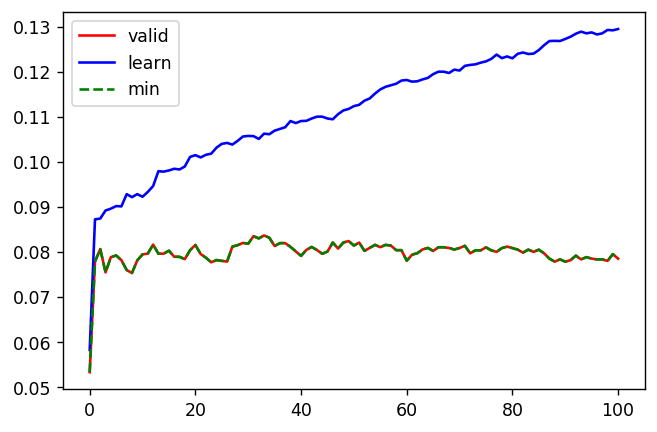

In [0]:
import matplotlib.pyplot as plt
plt.figure(dpi = 125)
plt.plot(valid_score_list, 'r', label="valid")
plt.plot(learn_score_list, 'b', label="learn")
plt.plot(np.min([valid_score_list,learn_score_list], axis=0), 'g--', label="min")
plt.legend()

In [0]:
df_features.columns[np.argsort(importance)[::-1]][:100], df_features.columns[np.argsort(importance)[::-1]][100:]

(Index(['first_redeem_time', 'z_score_on_first_redeem_time',
        'dev_from_median_on_first_redeem_time',
        'dev_from_mean_on_first_redeem_time',
        'dev_from_mean_on_regular_points_received_sum_last_month',
        'dev_from_mean_on_express_points_spent_new',
        'regular_points_received_sum_last_month', 'log_on_second_product_sum',
        'log_on_express_points_spent_new', 'express_points_spent_new',
        'z_score_on_express_points_spent_new',
        'dev_from_median_on_favorite_product_sum',
        'dev_from_mean_on_second_product_sum', 'z_score_on_purchases_count',
        'last_month_trans_count', 'log_on_sum_new',
        'dev_from_median_on_issue_redeem_delay',
        'dev_from_mean_on_issue_redeem_delay', 'z_score_on_issue_redeem_delay',
        'z_score_on_shop_count', 'dev_from_median_on_shop_count',
        'log_on_shop_count', 'dev_from_mean_on_shop_count',
        'log_on_store_id_sum_last_month', 'log_on_first_issue_time',
        'dev_from_median

In [0]:
 # Подготовка предсказаний для тестовых клиентов
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=56, shuffle=False)

treatment_learn_train = df_train.loc[indices_learn, 'treatment_flg'].values
treatment_learn_valid = df_train.loc[indices_valid, 'treatment_flg'].values

target_learn_train = df_train.loc[indices_learn, 'target'].values
target_learn_valid = df_train.loc[indices_valid, 'target'].values
learn_score_list=[]
valid_score_list=[]
it = 0

test_uplift, importance, test_model = uplift_fit_predict_transformation_custom(
    model = CatBoostClassifier(metric_period=10, 
                              verbose=100,
                              l2_leaf_reg=10, 
                              learning_rate=0.01, 
                              depth=4, 
                              langevin=True,
                              iterations=1000,
                              loss_function='Logloss',
                              eval_metric=UpliftMetric(),
                              use_best_model=True,
                              random_strength=0.1,#0,2,
                              #task_type='GPU',
                              per_float_feature_quantization=['11:border_count=1024','38:border_count=1024'],
                              #cat_features = cat_ind
                              ),
    X_train = df_features.loc[indices_learn, :].fillna(0).values,
    y_train = transformtaion(df_train).loc[indices_learn, 'transform_target'].fillna(0).values,
    X_test = test.values,
    X_valid = df_features.loc[indices_valid, :].fillna(0).values,
    y_valid = transformtaion(df_train).loc[indices_valid, 'transform_target'].fillna(0).values,
)

df_submission = pandas.DataFrame({'uplift': test_uplift}, index=df_test.index)
df_submission.to_csv('/data/My Drive/Colab Notebooks/data/submission.csv')

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 179ms	remaining: 2m 58s
100:	learn: 0.0897937	test: 0.0897937	best: 0.0904908 (90)	total: 8.56s	remaining: 1m 16s
200:	learn: 0.1030613	test: 0.0902255	best: 0.0924672 (180)	total: 16.8s	remaining: 1m 6s
300:	learn: 0.1127483	test: 0.0954109	best: 0.0954109 (300)	total: 25.2s	remaining: 58.4s
400:	learn: 0.1210951	test: 0.0958247	best: 0.0958247 (400)	total: 33.3s	remaining: 49.8s
500:	learn: 0.1323868	test: 0.0945808	best: 0.0958247 (400)	total: 41.8s	remaining: 41.6s
600:	learn: 0.1409244	test: 0.0925679	best: 0.0958247 (400)	total: 50.2s	remaining: 33.3s
700:	learn: 0.1498909	test: 0.0926471	best: 0.0958247 (400)	total: 58.8s	remaining: 25.1s
800:	learn: 0.1583718	test: 0.0925224	best: 0.0958247 (400)	total: 1m 7s	remaining: 16.7s
900:	learn: 0.1632879	test: 0.0919500	best: 0.0958247 (400)	total: 1m 15s	remaining: 8.25s
999:	learn: 0.1688678	test: 0.0911462	best: 0.0958247 (400)	total: 1m 23s	remaining: 0us

bestTest = 0

In [0]:
df_submission = pandas.DataFrame({'uplift': test_uplift}, index=df_test.index)
df_submission.to_csv('/data/My Drive/Colab Notebooks/data/submission.csv')

In [0]:
valid_score = uplift_score(
    test_model.predict_proba(df_features.loc[indices_valid, :].fillna(0).values)[:,1],
    treatment=df_train.loc[indices_valid, 'treatment_flg'].values,
    target=df_train.loc[indices_valid, 'target'].values,
)
print('Validation score on valid:', valid_score)

valid_score1 = uplift_score(
    test_model.predict_proba(df_features.loc[indices_learn, :].fillna(0).values)[:,1],
    treatment=df_train.loc[indices_learn, 'treatment_flg'].values,
    target=df_train.loc[indices_learn, 'target'].values,
)
print('Validation score on learn:', valid_score1)

valid_score2 = uplift_score(
    test_model.predict_proba(df_features.loc[indices_train, :].fillna(0).values)[:,1],
    treatment=df_train.loc[indices_train, 'treatment_flg'].values,
    target=df_train.loc[indices_train, 'target'].values,
)
print('Validation score on all train:', valid_score2)

Validation score on valid: 0.09582472908655854
Validation score on learn: 0.12109512546885032
Validation score on all train: 0.11346292312065376


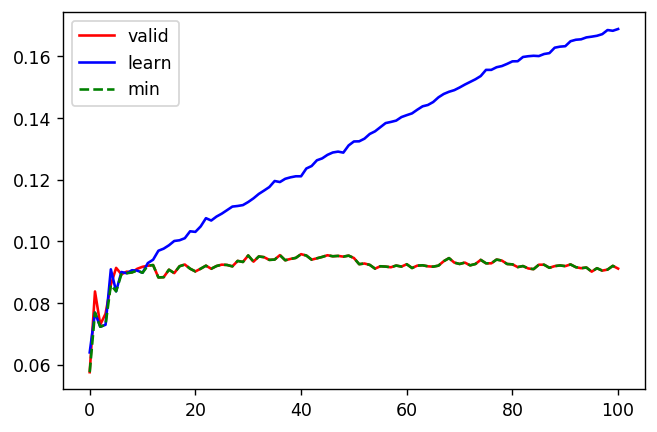

In [0]:
import matplotlib.pyplot as plt
plt.figure(dpi = 125)
plt.plot(valid_score_list, 'r', label="valid")
plt.plot(learn_score_list, 'b', label="learn")
plt.plot(np.min([valid_score_list,learn_score_list], axis=0), 'g--', label="min")
plt.legend()

In [0]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import roc_auc_score

indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=56, shuffle=True)

treatment_valid = df_train.loc[indices_valid, 'treatment_flg'].values
target_valid = df_train.loc[indices_valid, 'target'].values

ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.001, 0.011, 0.001)),
    'max_depth':         hp.choice('max_depth',         np.arange(2, 11, 1, dtype=int)),
    'iterations':        hp.choice('iterations',        np.arange(400, 1100, 100)),
    'l2_leaf_reg':       hp.choice('l2_leaf_reg',       np.arange(1, 21, 1)),
    #'langevin':          True,
    'eval_metric':       'AUC',
    'task_type':         'GPU',
    'random_strength':   hp.choice('random_strength',   np.arange(0.05, 0.21, 0.05)),
}
ctb_fit_params = {
    'early_stopping_rounds': 100,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: 1-uplift_score(pred, treatment_valid, target_valid)

In [0]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def ctb_reg(self, para):
        reg = ctb.CatBoostClassifier(**para['reg_params'])
        return self.train_reg(reg, para)
      
    def xgb_reg(self, para):
        reg = xgb.XGBClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_test, self.y_test)],
                **para['fit_params'])
        pred = 2*reg.predict_proba(self.x_test)[:,1]-1
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [0]:
X_train = df_features.loc[indices_learn, :].fillna(0).values
y_train = transformtaion(df_train).loc[indices_learn, 'transform_target'].fillna(0).values
X_valid = df_features.loc[indices_valid, :].fillna(0).values
y_valid = transformtaion(df_train).loc[indices_valid, 'transform_target'].fillna(0).values

In [0]:
obj = HPOpt(X_train, X_valid, y_train, y_valid)

ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [10:35<00:00,  4.93s/it, best loss: 0.9068830143619366]


In [0]:
ctb_params = {
    'learning_rate':     np.arange(0.001, 0.011, 0.001),
    'max_depth':         np.arange(2, 11, 1, dtype=int),
    'iterations':        np.arange(400, 1100, 100),
    'l2_leaf_reg':       np.arange(1, 21, 1),
    'langevin':          True,
    'eval_metric':       'AUC',
    'random_strength':   np.arange(0.05, 0.21, 0.05),
    'verbose':100,
}

for c in ctb_opt[0]:
  ctb_params[c] = ctb_params[c][ctb_opt[0][c]]

In [0]:
model = CatBoostClassifier(**ctb_params)

X_train = df_features.loc[indices_learn, :].fillna(0).values
y_train = transformtaion(df_train).loc[indices_learn, 'transform_target'].fillna(0).values

model.fit(df_features.fillna(0).values, transformtaion(df_train)['transform_target'].fillna(0).values)

0:	total: 117ms	remaining: 1m 44s
100:	total: 12.3s	remaining: 1m 37s
200:	total: 25.2s	remaining: 1m 27s
300:	total: 38.2s	remaining: 1m 16s
400:	total: 51.2s	remaining: 1m 3s
500:	total: 1m 4s	remaining: 51.3s
600:	total: 1m 18s	remaining: 38.9s
700:	total: 1m 30s	remaining: 25.8s
800:	total: 1m 43s	remaining: 12.8s
899:	total: 1m 56s	remaining: 0us


In [0]:
upl = 2*model.predict_proba(test)[:,1]-1
df_submission = pandas.DataFrame({'uplift': upl}, index=df_test.index)
df_submission.to_csv('/data/My Drive/Colab Notebooks/data/submission.csv')